## Libs

In [1]:
import os
import torch
from torch.autograd import Variable

import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

from router import models
from tacotron2.text import text_to_sequence
from common.utils import load_wav_to_torch, to_gpu
from common.layers import TacotronSTFT
from configs import Config as hp

FileNotFoundError: [Errno 2] No such file or directory: '/train/speaker_coefficients.json'

## Paths to checkpoints

In [3]:
#taco_path = '/workspace/output/gst_lj/checkpoint_Tacotron2_1500'
#wg_path   = '/workspace/output/sm_wg/checkpoint_WaveGlow_1750'
wg_path  = '/data/pretrained/wg_fp32_torch'
taco_path = '/data/pretrained/emotions_checkpoint_1000'

## Load models

In [96]:
taco_checkpoint = torch.load(taco_path, map_location='cpu')
wg_checkpoint = torch.load(wg_path, map_location='cpu')

In [97]:
t2 = models.get_model('Tacotron2', taco_checkpoint['config'], to_cuda=True)
wg = models.get_model('WaveGlow', wg_checkpoint['config'], to_cuda=True)

In [98]:
for model, checkpoint in [(t2, taco_checkpoint), (wg, wg_checkpoint)]:
    new_state_dict = {}
    for key, value in checkpoint['state_dict'].items():
        new_key = key.replace('module.', '')
        new_state_dict[new_key] = value

    model.load_state_dict(new_state_dict)

In [1]:
t2.eval()
wg.eval()
print('Done')

NameError: name 't2' is not defined

## Set speaker and text

In [100]:
text = "hello. how are you today?"
speaker_id = 0
emotion_id = 0

## Infer

In [170]:
inputs = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
inputs = torch.from_numpy(inputs).to(device='cuda', dtype=torch.int64)
speaker_id = torch.IntTensor([speaker_id]).cuda().long()
emotion_id = torch.IntTensor([emotion_id]).cuda().long()

In [171]:
with torch.no_grad():
    _, mel, _, _ = t2.infer(inputs, speaker_id, emotion_id)
    audio = wg.infer(mel)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


style_embeddings torch.Size([1, 1, 256])
style_embeddings exp. torch.Size([1, 25, 256])


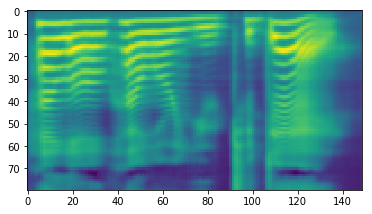

In [172]:
plt.imshow(mel.squeeze(0).detach().cpu().numpy())

In [173]:
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

In [174]:
Audio(audio_numpy, rate=rate)

## Speaker footprint

In [175]:
embedded_speaker = t2.speakers_embedding(speaker_id)

In [176]:
embedded_speaker

tensor([[ 4.5953e-03, -8.6826e-06,  1.5722e-03, -3.2818e-08,  3.9683e-06,
          3.2565e-02,  1.0630e-05, -1.2436e-05,  5.9308e-06, -2.1336e-02,
          1.0308e-05,  7.8969e-07,  2.0220e-06,  5.8132e-06, -7.2838e-06,
         -1.2582e-03]], device='cuda:0', grad_fn=<EmbeddingBackward>)

## Speaker footprint


In [ ]:
embedded_emotion = t2.emotions_embedding(emotion_id)

In [ ]:
embedded_emotion
